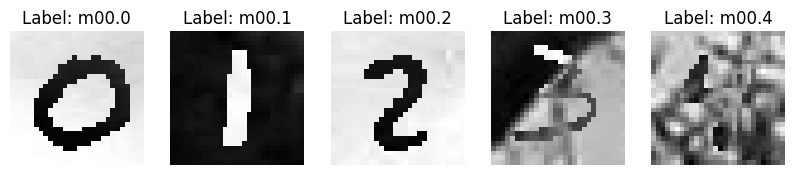

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%pip install seaborn
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
#%pip install opencv-python
import cv2

# 1. Carga y visualización de ejemplos de cada modalidad
def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                img = cv2.imread(os.path.join(subfolder_path, filename), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    # Conservar el nombre '0.0' y eliminar 'png'
                    label = subfolder+".".join(filename.split('.')[:-1])
                    labels.append(label)
                else:
                    print(f'Error al cargar la imagen {filename}')
    return np.array(images), np.array(labels)

# Cambia el path a la carpeta donde descargaste el dataset PolyMNIST
train_folder_path = './MMNIST/train'
test_folder_path = './MMNIST/test'

train_images, train_labels = load_images_from_folder(train_folder_path)
test_images, test_labels = load_images_from_folder(test_folder_path)

# Visualizar algunos ejemplos de las modalidades
def show_samples(images, labels, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

show_samples(train_images, train_labels)



### Análisis Exploratorio

In [2]:
# Obtener estadísticas básicas
pixel_values = train_images.ravel()

print(f"Valor mínimo de píxel: {pixel_values.min()}")
print(f"Valor máximo de píxel: {pixel_values.max()}")
print(f"Valor medio de píxel: {pixel_values.mean()}")
print(f"Desviación estándar de píxel: {pixel_values.std()}")


Valor mínimo de píxel: 0
Valor máximo de píxel: 255
Valor medio de píxel: 110.1164056207483
Desviación estándar de píxel: 67.91179795996366


In [3]:
# Detección de imágenes que son completamente negras (o casi)
# Para imágenes en escala de grises, el array `train_images` tiene 3 dimensiones: (num_imagenes, altura, anchura)
black_images = np.sum(train_images == 0, axis=(1, 2)) == (train_images.shape[1] * train_images.shape[2])
num_black_images = np.sum(black_images)

print(f"Imágenes completamente negras: {num_black_images}")

# Visualizar algunas imágenes negras (si las hay)
if num_black_images > 0:
    show_samples(train_images[black_images], train_labels[black_images])


Imágenes completamente negras: 0


Resolución de las imágenes en train : (28, 28)
Resolución de las imágenes: (28, 28)
Distribución de las clases por prefijo en el conjunto de datos train:
m0    60000
m1    60000
m2    60000
m3    60000
m4    60000
dtype: int64


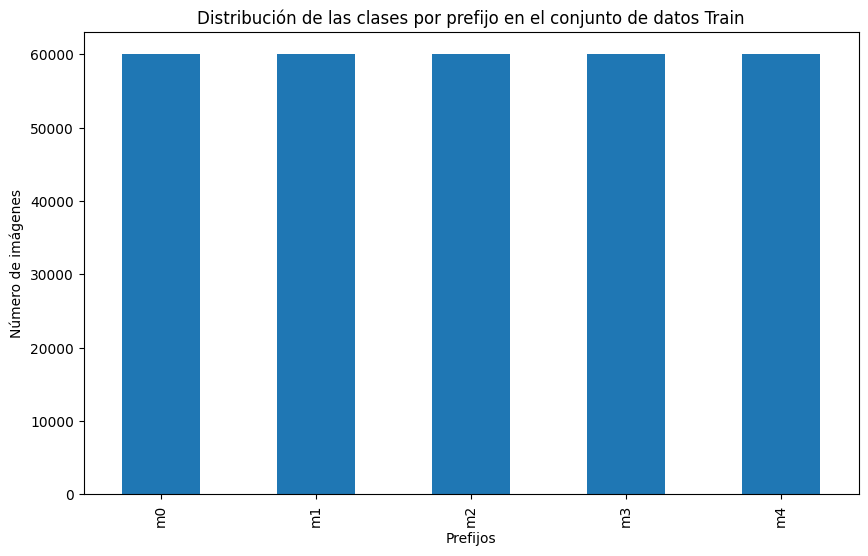

Distribución de las clases por prefijo en el conjunto de datos Test:
m0    10000
m1    10000
m2    10000
m3    10000
m4    10000
dtype: int64


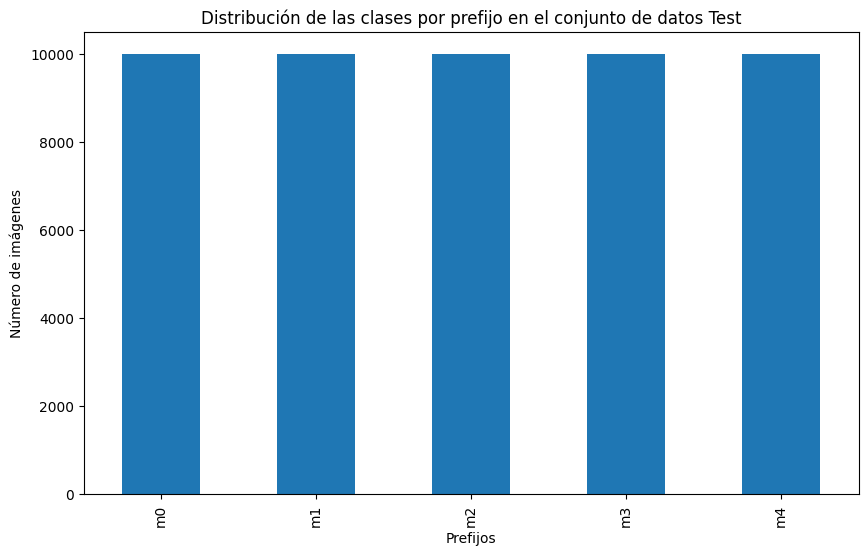

¿Está el conjunto de datos train balanceado por prefijos? True
¿Está el conjunto de datos test balanceado por prefijos? True


In [4]:
# Función para agrupar las etiquetas por prefijo (m0, m1, m2, m3, m4)
def group_labels_by_prefix(labels):
    grouped = {
        'm0': 0,
        'm1': 0,
        'm2': 0,
        'm3': 0,
        'm4': 0
    }
    for label in labels:
        prefix = label[:2]
        if prefix in grouped:
            grouped[prefix] += 1
    return pd.Series(grouped)

# Especificar la resolución de las imágenes
train_image_shape = train_images.shape[1:]
print(f"Resolución de las imágenes en train : {train_image_shape}")

# Especificar la resolución de las imágenes
test_image_shape = test_images.shape[1:]
print(f"Resolución de las imágenes: {test_image_shape}")

# Analizar la distribución del conjunto de datos por prefijo
train_prefix_distribution = group_labels_by_prefix(train_labels)
print("Distribución de las clases por prefijo en el conjunto de datos train:")
print(train_prefix_distribution)

# Visualizar la distribución por prefijo en el conjunto de datos train
plt.figure(figsize=(10, 6))
train_prefix_distribution.plot(kind='bar')
plt.title('Distribución de las clases por prefijo en el conjunto de datos Train')
plt.xlabel('Prefijos')
plt.ylabel('Número de imágenes')
plt.show()

# Analizar la distribución del conjunto de datos por prefijo para el conjunto de test
test_prefix_distribution = group_labels_by_prefix(test_labels)
print("Distribución de las clases por prefijo en el conjunto de datos Test:")
print(test_prefix_distribution)

# Visualizar la distribución por prefijo en el conjunto de datos Test
plt.figure(figsize=(10, 6))
test_prefix_distribution.plot(kind='bar')
plt.title('Distribución de las clases por prefijo en el conjunto de datos Test')
plt.xlabel('Prefijos')
plt.ylabel('Número de imágenes')
plt.show()

# Verificar si el conjunto de datos está balanceado por prefijos
balanced_train = train_prefix_distribution.min() == train_prefix_distribution.max()
print(f"¿Está el conjunto de datos train balanceado por prefijos? {balanced_train}")

balanced_test = test_prefix_distribution.min() == test_prefix_distribution.max()
print(f"¿Está el conjunto de datos test balanceado por prefijos? {balanced_test}")


### Modelos de Deep Learning y Modelo de Red neuronal Simple

Epoch 1/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 96s 10ms/step - accuracy: 0.7945 - loss: 0.5072 - val_accuracy: 0.9018 - val_loss: 0.2374
Epoch 2/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.9161 - loss: 0.2181 - val_accuracy: 0.9307 - val_loss: 0.1752
Epoch 3/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 102s 11ms/step - accuracy: 0.9375 - loss: 0.1655 - val_accuracy: 0.9434 - val_loss: 0.1537
Epoch 4/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 95s 10ms/step - accuracy: 0.9451 - loss: 0.1451 - val_accuracy: 0.9266 - val_loss: 0.1817
Epoch 5/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 91s 10ms/step - accuracy: 0.9527 - loss: 0.1267 - val_accuracy: 0.9611 - val_loss: 0.1098
Epoch 6/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 78s 8ms/step - accuracy: 0.9588 - loss: 0.1106 - val_accuracy: 0.9525 - val_loss: 0.1364
Epoch 7/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - accuracy: 0.9629 - loss: 0.1006 - val_accuracy: 0.9547 - val_loss: 0.1377
Epoch 8/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.9657 - lo

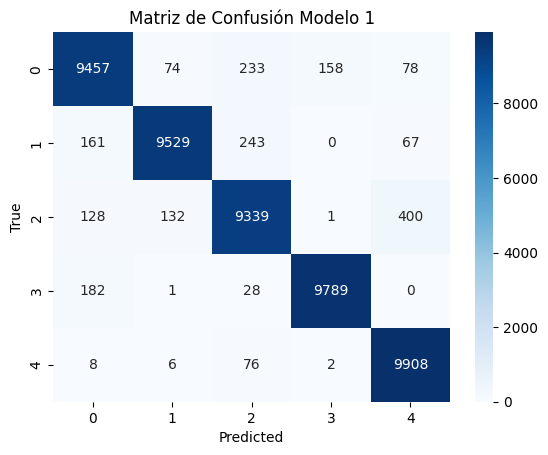

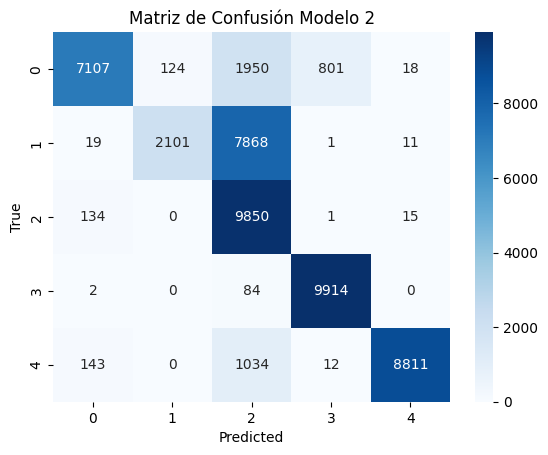

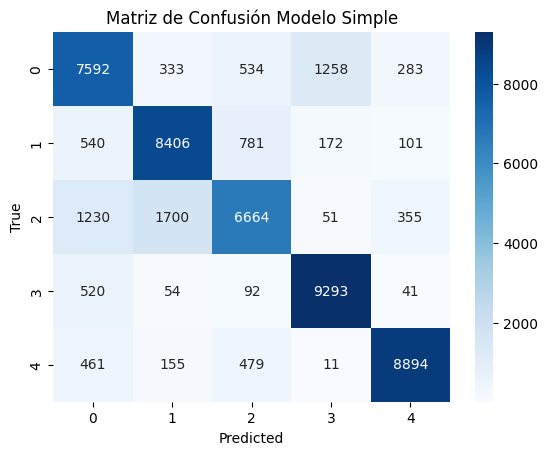

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
# Verificar y corregir dimensiones
def check_and_fix_image_dimensions(images):
    # Si las imágenes tienen 3 dimensiones (n_samples, height, width), agrega el canal
    if len(images.shape) == 3:
        images = np.expand_dims(images, axis=-1)
    # Si las imágenes tienen más de 4 dimensiones, eliminar dimensiones extra
    elif len(images.shape) > 4:
        images = images.squeeze()  # Eliminar dimensiones innecesarias
    return images

train_images = check_and_fix_image_dimensions(train_images)
test_images = check_and_fix_image_dimensions(test_images)

# Normalización de las imágenes
train_images = train_images / 255.0
test_images = test_images / 255.0

# Diccionario de mapeo
label_mapping = {
    'm0': 1,
    'm1': 2,
    'm2': 3,
    'm3': 4,
    'm4': 5
}

# Función para extraer el prefijo y mapearlo
def map_labels(labels):
    mapped_labels = []
    for label in labels:
        prefix = label.split('.')[0][:2]  # Extrae 'm0', 'm1', etc.
        mapped_labels.append(label_mapping[prefix] - 1)  # Resta 1 para empezar desde 0
    return np.array(mapped_labels)

# Aplicar la función de mapeo a las etiquetas
train_labels_mapped = map_labels(train_labels)
test_labels_mapped = map_labels(test_labels)

# One-hot encoding de las etiquetas
num_classes = len(label_mapping)  # Hay 5 clases (m0 a m4)
train_labels_categorical = to_categorical(train_labels_mapped, num_classes=num_classes)
test_labels_categorical = to_categorical(test_labels_mapped, num_classes=num_classes)

# Modelo 1: CNN Simple
model_1 = Sequential([
    Input(shape=(train_images.shape[1], train_images.shape[2], 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo 1
history_1 = model_1.fit(train_images, train_labels_categorical, validation_data=(test_images, test_labels_categorical), epochs=10, batch_size=32)

# Evaluación del modelo 1
y_pred_1 = model_1.predict(test_images)
y_pred_1_classes = np.argmax(y_pred_1, axis=1)
y_true = np.argmax(test_labels_categorical, axis=1)

print("Modelo 1: Reporte de Clasificación")
print(classification_report(y_true, y_pred_1_classes))

# Modelo 2: CNN con Dropout y Batch Normalization
model_2 = Sequential([
    Input(shape=(train_images.shape[1], train_images.shape[2], 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo 2
history_2 = model_2.fit(train_images, train_labels_categorical, validation_data=(test_images, test_labels_categorical), epochs=10, batch_size=32)

# Evaluación del modelo 2
y_pred_2 = model_2.predict(test_images)
y_pred_2_classes = np.argmax(y_pred_2, axis=1)

print("Modelo 2: Reporte de Clasificación")
print(classification_report(y_true, y_pred_2_classes))

# Modelo 3: Red Neuronal Simple (sin convoluciones)
model_simple = Sequential([
    Input(shape=(train_images.shape[1], train_images.shape[2], 1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo simple
history_simple = model_simple.fit(train_images, train_labels_categorical, validation_data=(test_images, test_labels_categorical), epochs=10, batch_size=32)

# Evaluación del modelo simple
y_pred_simple = model_simple.predict(test_images)
y_pred_simple_classes = np.argmax(y_pred_simple, axis=1)

print("Modelo Simple: Reporte de Clasificación")
print(classification_report(y_true, y_pred_simple_classes))

# Matrices de confusión para cada modelo
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_true, y_pred_1_classes, "Matriz de Confusión Modelo 1")
plot_confusion_matrix(y_true, y_pred_2_classes, "Matriz de Confusión Modelo 2")
plot_confusion_matrix(y_true, y_pred_simple_classes, "Matriz de Confusión Modelo Simple")

In [7]:
print("Modelo 1: Reporte de Clasificación")
print(classification_report(y_true, y_pred_1_classes))

print("Modelo 2: Reporte de Clasificación")
print(classification_report(y_true, y_pred_2_classes))

Modelo 1: Reporte de Clasificación
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       0.98      0.95      0.97     10000
           2       0.94      0.93      0.94     10000
           3       0.98      0.98      0.98     10000
           4       0.95      0.99      0.97     10000

    accuracy                           0.96     50000
   macro avg       0.96      0.96      0.96     50000
weighted avg       0.96      0.96      0.96     50000

Modelo 2: Reporte de Clasificación
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     10000
           1       0.94      0.21      0.34     10000
           2       0.47      0.98      0.64     10000
           3       0.92      0.99      0.96     10000
           4       1.00      0.88      0.93     10000

    accuracy                           0.76     50000
   macro avg       0.86      0.76      0.74     50000
weighte

In [8]:
print("Modelo Simple: Reporte de Clasificación")
print(classification_report(y_true, y_pred_simple_classes))

Modelo Simple: Reporte de Clasificación
              precision    recall  f1-score   support

           0       0.73      0.76      0.75     10000
           1       0.79      0.84      0.81     10000
           2       0.78      0.67      0.72     10000
           3       0.86      0.93      0.89     10000
           4       0.92      0.89      0.90     10000

    accuracy                           0.82     50000
   macro avg       0.82      0.82      0.82     50000
weighted avg       0.82      0.82      0.82     50000



### Modelo Adiciona (SVM)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Redimensionar las imágenes y aplanar para usar con SVM
X_train_flat = train_images.reshape((train_images.shape[0], -1))
X_test_flat = test_images.reshape((test_images.shape[0], -1))

# Crear y entrenar el modelo SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_flat, train_labels)

# Hacer predicciones
y_pred_svm = svm_model.predict(X_test_flat)

# Evaluar el modelo
print("SVM: Reporte de Clasificación")
print(classification_report(test_labels, y_pred_svm))


### Image Augmentation y reentrenamiento

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir el generador de datos con aumento de imagen
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Reentrenar el modelo CNN con los datos aumentados
model_augmented = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model_augmented.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ajustar el modelo usando el generador de datos
model_augmented.fit(datagen.flow(train_images, train_labels_categorical, batch_size=32), epochs=10, validation_data=(test_images, test_labels_categorical))

# Evaluación del modelo
y_pred_augmented = model_augmented.predict(test_images)
y_pred_augmented_classes = np.argmax(y_pred_augmented, axis=-1)
print("CNN con Image Augmentation: Reporte de Clasificación")
print(classification_report(test_labels, y_pred_augmented_classes))
